In [1]:
from mido import Message, MidiFile, MidiTrack, MetaMessage, bpm2tempo
import mido
import pandas as pd
import numpy as np
import os
import glob
import cv2 as cv
import random
import matplotlib.pyplot as plt

In [2]:
class MidiData:

    def __init__(self, midi_file,image_folder="images",image_prefix=None):

        self.midi = MidiFile(midi_file)
        self.drum_track_indxs = self._get_drum_idx(self.midi.tracks)
        self.ticks_per_beat = self.midi.ticks_per_beat
        self.ticks_per_32nt = self.ticks_per_beat/8
        self.df = None
        self.img_folder = image_folder
        self.img_prefix = image_prefix

        
    def _get_drum_idx(self,tracks):
        drum_idx = set()
        for idx,track in enumerate(tracks):
            for message in track:
                if type(message) == mido.messages.messages.Message:
                    if message.channel == 9:
                        drum_idx.add(idx)
                    continue
        
        return drum_idx
        
    def midi_to_df(self):
        
        drum_tracks = []
        # loop through each drum channel
        for idx in self.drum_track_indxs:
            drum_track = self.midi.tracks[idx]
            
            df = pd.DataFrame([m.dict() for m in drum_track])

            df = df[df['channel'].notna()] # drop the metamessages

            # get time passed since the first message and quantize
            df.time = [round(sum(df.time[0:i])/self.ticks_per_32nt)
                       for i in range(1, len(df)+1)]
            df = df[df.type == 'note_on']
            df = df.pivot_table(index='time', columns='note',
                                values='velocity', fill_value=0)

            #df = self.drop_some_notes(df)
            drum_tracks.append(df)
        
        # if there are more than 1 drum channel, merge them
        if len(self.drum_track_indxs) > 1:
            new_df = pd.concat(drum_tracks)
            new_df = new_df.groupby('time').sum()
        else:
            new_df = drum_tracks[0]
            
        new_df = new_df.reindex(pd.RangeIndex(new_df.index.max()+1)).fillna(0).sort_index()
        new_df = new_df.rename(columns={35:36}) # convert acoustic bass drum to bass drum  

        # if velocity > 0, change it to 1
        new_df = (new_df > 0).astype(int)
        new_df.columns = new_df.columns.astype(int)
        
        self.df = new_df
        
    def convert_df_to_image(self,image_size=512,step=32,min_max_note=None):
        full_song_image = np.ones((106,len(self.df)))
        # first create the full song image
        for idx,row in self.df.iterrows():
            notes = row[row == 1].index

            if len(notes) > 0:
                full_song_image[notes,idx] = 0
        
        start_idx = 0
        # divide the full song image into given image size and with ovelap of step
        while True:
            if start_idx + image_size > full_song_image.shape[1]:
                break
                
            image = full_song_image[:,start_idx:start_idx + image_size]
            
            if min_max_note != None:
                min_note,max_note = min_max_note
                image = image[min_note:max_note+1,:]
            
    
            if (image != 1).nonzero()[0].sum() != 0:
                print(f"{self.img_folder}/{self.img_prefix}_{start_idx}.png")
                cv.imwrite(f"{self.img_folder}/{self.img_prefix}_{start_idx}.png",image*255)
                
            start_idx += step
            

In [3]:
# get all the midi files
midi_files = glob.glob("midi-files/*.mid")
midi_files

['midi-files\\age-of-excuse-1.mid',
 'midi-files\\age-of-excuse-2.mid',
 'midi-files\\age-of-excuse-3.mid',
 'midi-files\\age-of-excuse-4.mid',
 'midi-files\\age-of-excuse-5.mid',
 'midi-files\\age-of-excuse-6.mid',
 'midi-files\\exercises-in-futility-1.mid',
 'midi-files\\exercises-in-futility-3.mid',
 'midi-files\\exercises-in-futility-4.mid',
 'midi-files\\exercises-in-futility-5.mid',
 'midi-files\\exercises-in-futility-6.mid',
 'midi-files\\residual-blight.mid',
 'midi-files\\the-pallid-scourge.mid',
 'midi-files\\with-hearts-toward-none-7.mid']

In [5]:
# loop through each midifile
for file in midi_files:
    img_prefix = file.split("\\")[1].split(".")[0]
    # instantiate mididata class
    midi_data = MidiData(midi_file=file,image_folder="dataset",image_prefix=img_prefix)
    # convert drum track to df (Quantization)
    midi_data.midi_to_df()
    # convert dataframe into image
    midi_data.convert_df_to_image(image_size=256,step=128,min_max_note=(36,60))

dataset/age-of-excuse-1_0.png
dataset/age-of-excuse-1_128.png
dataset/age-of-excuse-1_256.png
dataset/age-of-excuse-1_384.png
dataset/age-of-excuse-1_512.png
dataset/age-of-excuse-1_640.png
dataset/age-of-excuse-1_768.png
dataset/age-of-excuse-1_896.png
dataset/age-of-excuse-1_1024.png
dataset/age-of-excuse-1_1152.png
dataset/age-of-excuse-1_1280.png
dataset/age-of-excuse-1_1408.png
dataset/age-of-excuse-1_1536.png
dataset/age-of-excuse-1_1664.png
dataset/age-of-excuse-1_1792.png
dataset/age-of-excuse-1_1920.png
dataset/age-of-excuse-1_2048.png
dataset/age-of-excuse-1_2176.png
dataset/age-of-excuse-1_2304.png
dataset/age-of-excuse-1_2432.png
dataset/age-of-excuse-1_2560.png
dataset/age-of-excuse-1_2688.png
dataset/age-of-excuse-1_2816.png
dataset/age-of-excuse-1_2944.png
dataset/age-of-excuse-1_3072.png
dataset/age-of-excuse-1_3200.png
dataset/age-of-excuse-1_3328.png
dataset/age-of-excuse-1_3456.png
dataset/age-of-excuse-1_3584.png
dataset/age-of-excuse-1_3712.png
dataset/age-of-excus

dataset/age-of-excuse-6_128.png
dataset/age-of-excuse-6_256.png
dataset/age-of-excuse-6_384.png
dataset/age-of-excuse-6_512.png
dataset/age-of-excuse-6_640.png
dataset/age-of-excuse-6_768.png
dataset/age-of-excuse-6_896.png
dataset/age-of-excuse-6_1024.png
dataset/age-of-excuse-6_1152.png
dataset/age-of-excuse-6_1280.png
dataset/age-of-excuse-6_1408.png
dataset/age-of-excuse-6_1536.png
dataset/age-of-excuse-6_1664.png
dataset/age-of-excuse-6_1792.png
dataset/age-of-excuse-6_1920.png
dataset/age-of-excuse-6_2048.png
dataset/age-of-excuse-6_2176.png
dataset/age-of-excuse-6_2304.png
dataset/age-of-excuse-6_2432.png
dataset/age-of-excuse-6_2560.png
dataset/age-of-excuse-6_2688.png
dataset/age-of-excuse-6_2816.png
dataset/age-of-excuse-6_2944.png
dataset/age-of-excuse-6_3072.png
dataset/age-of-excuse-6_3200.png
dataset/age-of-excuse-6_3328.png
dataset/age-of-excuse-6_3456.png
dataset/age-of-excuse-6_3584.png
dataset/age-of-excuse-6_3712.png
dataset/age-of-excuse-6_3840.png
dataset/age-of-ex

dataset/exercises-in-futility-6_1280.png
dataset/exercises-in-futility-6_1408.png
dataset/exercises-in-futility-6_1536.png
dataset/exercises-in-futility-6_1664.png
dataset/exercises-in-futility-6_1792.png
dataset/exercises-in-futility-6_1920.png
dataset/exercises-in-futility-6_2048.png
dataset/exercises-in-futility-6_2176.png
dataset/exercises-in-futility-6_2304.png
dataset/exercises-in-futility-6_2432.png
dataset/exercises-in-futility-6_2560.png
dataset/exercises-in-futility-6_2688.png
dataset/exercises-in-futility-6_2816.png
dataset/exercises-in-futility-6_2944.png
dataset/exercises-in-futility-6_3072.png
dataset/exercises-in-futility-6_3200.png
dataset/exercises-in-futility-6_3328.png
dataset/exercises-in-futility-6_3456.png
dataset/exercises-in-futility-6_3584.png
dataset/exercises-in-futility-6_3712.png
dataset/exercises-in-futility-6_3840.png
dataset/exercises-in-futility-6_3968.png
dataset/exercises-in-futility-6_4096.png
dataset/exercises-in-futility-6_4224.png
dataset/exercise

<text> Visualize a random sample from the dataset. </text>

In [6]:
image_files = glob.glob("dataset/*.png")

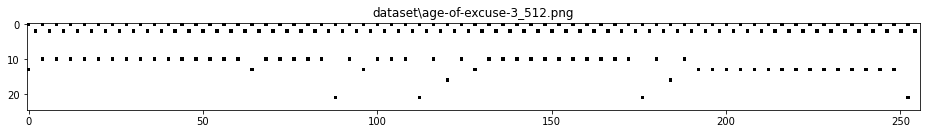

In [10]:
sample_idx = random.randint(0,len(image_files))

file_name = image_files[sample_idx]
img = cv.imread(file_name)
img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

plt.figure(figsize=(16,9))
plt.title(file_name)
plt.imshow(img,'gray')